# Variable dz water balance

The purpose of this script is to be able to monitor a run's progress and view how the water balance is progressing (for example during spinup). It should take into consideration variable dz adjustments

In [37]:
from postproc import scale_pfb
import numpy as np

import subprocess
import glob
import os
import shutil
import time
import pandas as pd
from io import StringIO

%matplotlib inline

## Subsurface storage (summing the converted vdz .pfb files over entire domain)

Time Elapsed:  0.04006075859069824 s


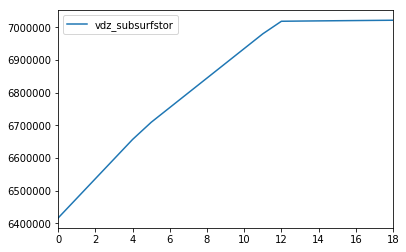

In [41]:
# The following runs the tcl file, with a runtime argument (the index of the last file name)
start = time.time()
bashCommand = "tclsh sum_domain_example.tcl 19"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

# Save the output to a dataframe
output = output.decode("utf-8").format()
df = pd.read_csv(StringIO(output), sep="\t", header = None)
df.columns = ['vdz_subsurfstor']  # add a header (column name)
df.plot.line() # plot line

end = time.time()
print('Time Elapsed:  %s s' %(end - start))

In [50]:
df.vdz_subsurfstor.pct_change()*100 # These are changing by such little percentages, because layers too thick probably...

0          NaN
1     0.935030
2     0.926369
3     0.917866
4     0.909518
5     0.788163
6     0.671977
7     0.667476
8     0.663036
9     0.658654
10    0.654331
11    0.650065
12    0.550245
13    0.008809
14    0.007537
15    0.007277
16    0.007077
17    0.006921
18    0.006796
Name: vdz_subsurfstor, dtype: float64

## Overland Flow